In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import quandl
import collections, functools, operator
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt  
import seaborn as seabornInstance
pd.set_option('mode.chained_assignment', None)
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from operator import itemgetter 
%matplotlib inline

In [19]:
#read in data
msf = pd.read_csv('msf.csv')
keep = remove_foreign_reit_adr()
msf = msf[msf['CUSIP'].isin(keep)]
msf['PRC'] = msf['PRC'].abs()
msf = msf[msf['date'] != 19251231]
msf = msf.drop(['TICKER', 'ACPERM'], axis=1)
msf['date'] = msf['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
data = check_larger_than_medium(msf)

In [2]:
def check_larger_than_medium(data):
    '''
    @author: Wuding Li
    @The function returns a dataframe that contains the permno that is larger than it's medium
    @Variable: data: the input dataset
    '''
    data['mkt_cap'] = data['PRC']*data['VOL']
    data["mkt_cap"] = data.groupby(['date'])['mkt_cap'].transform(lambda x: x.fillna(x.mean()))
    temp = data[data['PRIMEXCH'] == 'N']
    temp['mkt_cap'] = temp['PRC']*temp['VOL']
    temp["mkt_cap"] = temp.groupby(['date'])['mkt_cap'].transform(lambda x: x.fillna(x.mean()))
    temp['mkt_cap_median'] = temp.groupby('date')['mkt_cap'].transform('median')
    temp = temp[['date','mkt_cap_median']]
    temp = temp.drop_duplicates()
    temp = pd.merge(data, temp, how='left', on=['date'])
    output = temp[(temp['mkt_cap'] > temp['mkt_cap_median'])]
    return output

In [3]:
def remove_foreign_reit_adr():
    '''
    @author: Wuding Li
    @The function returns a list of CUSIPs which not been filtered out
    @Reference: The function get the REIT and Foreign Stock filter through the Quandl database
    '''
    quandl.ApiConfig.api_key = "wJQ9TBnyt36w1a-dZjDg"
    CUSIPdic = quandl.get_table("SHARADAR/TICKERS", paginate=True)
    #get all domestic stock
    domestic = CUSIPdic[CUSIPdic['category'] == 'Domestic']
    #remove REIT
    keep = domestic[domestic['sicindustry'] != 'Real Estate Investment Trusts']
    #get CUSIP for all those keep ticker
    keep_list = keep['cusips'].values.tolist()
    #adjust the format in keep_list
    keep_list = " ".join([i for i in keep_list if i]).split(' ')
    output = [x[:-1] for x in keep_list]
    return output

In [4]:
def check_more_than_5(data):
    '''
    @author: Wuding Li
    @The function returns a list of PERMNO which it's price in larger than $5 in the sampling and testing period
    @Variable: data: the input dataset
    '''
    mask = (data['PRC'] < 5)
    output = list(set((data.loc[mask])['PERMNO'].values.tolist()))
    return output

In [5]:
def remove_missing(data):
    '''
    @author: Wuding Li
    @The function returns a list of PERMMO that has missing values
    @Variable: data: the input dataset
    '''
    return list(set(data[data.isnull().any(axis=1)]['PERMNO'].values))

In [6]:
def check_closed_end_fund(data):
    '''
    @author: Wuding Li
    @The function return a list of PERMNO with no closed end fund
    @Variable: data: the input dataset
    '''
    
    date = data['date'].values
    s_date = [date[0]]
    PERMNO_list_start = (data[data['date'].isin(s_date)])['PERMNO'].values.tolist()
    
    e_date = [date[-1]]
    PERMNO_list_end = (data[data['date'].isin(e_date)])['PERMNO'].values.tolist()
    
    temp = set(PERMNO_list_end) 
    output = [value for value in PERMNO_list_start if value in temp] 
    
    return output

In [7]:
def rolling_time_window(Start_Month, Start_Year, Time_Period_Training, Time_Period_Testing, Gap, data):
    '''
    @author: Wuding Li
    @The function returns two cleaned datasets. One is the sampling period data and the other is testing period data
    @variables: Start_Month: the starting month of our rolling time period
                Start_Year: the starting year of our rolling time period
                Time_Period_Training: Span of sampling Period
                Time_Period_Testing: Span of testing Period
                Gap: Gap between sampling and testing
                Data: The input data dataset
    @Also this function apply the filter no closed end fund and stock price more than 5 dollars
    
    @Updated: 10/7 fixed the end_date_test "frequency = 0" problem
    @Updated: 10/16 change "DATE" to "date" to match the updated format
    '''
    
    #get the start and end date of data
    start_date_train = str(pd.date_range(start=str(Start_Month)+'/1/'+str(Start_Year), periods=1, freq='D')[0].date())
    end_date_train = str(pd.date_range(start=str(Start_Month)+'/1/'+str(Start_Year), periods=2, freq=str(Time_Period_Training-1)+'M')[-1].date())
    mask_train = (data['date'] >= start_date_train) & (data['date'] <= end_date_train)
    
    
    start_month_testing = Start_Month+Time_Period_Training+Gap
    if start_month_testing % 12 == 0:
        start_year_testing = Start_Year + math.floor(start_month_testing/12)-1
        start_month_testing = 12
    else:
        start_year_testing = Start_Year + math.floor(start_month_testing/12)
        start_month_testing = start_month_testing % 12    
    start_date_test = str(pd.date_range(start=str(start_month_testing)+'/1/'+str(start_year_testing), periods=1, freq='D')[0].date())
    end_date_test = str(pd.date_range(start=str(start_month_testing)+'/1/'+str(start_year_testing), periods=1, freq=str(Time_Period_Testing)+'M')[-1].date())
    mask_test = (data['date'] >= start_date_test) & (data['date'] <= end_date_test)
    
    #applying filter functions below on the master dataset
    mask_master = (data['date'] >= start_date_train) & (data['date'] <= end_date_test)
    data_master = data.loc[mask_master]
    
    #check closed end fund
    keep_list = check_closed_end_fund(data_master) 
    #check more than 5 and missing data
    delete_list = check_more_than_5(data_master) + remove_missing(data_master)
    
    #comprehend both list
    keep_list = [x for x in keep_list if x not in delete_list]
    
    data_master = data_master[data_master['PERMNO'].isin(keep_list)]
    
   # data_master = get_weight(data_master)
    #remove strings in columns
    data_master[['RET']] = data_master[['RET']].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float).dropna()
    data_master[['RETX']] = data_master[['RETX']].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float).dropna()
    
    full = []
    for i in data_master['PERMNO'].values:
        if (data_master[data_master['PERMNO'] == i]).shape[0] == (Time_Period_Training+ Time_Period_Testing+ Gap):
            full.append(i)
    data_master = data_master[data_master['PERMNO'].isin(full)]

    
    return data_master.loc[mask_train],data_master.loc[mask_test]


In [8]:
def format_FF():
    '''
    @author: Zhikang Wang
    @The function read and clean up the fama_french dataset pulled from Dr. French's website
    @Variable: input is fama_french dataset pulled from Dr. French's website
    '''
    
    ff_data = pd.read_csv("fama_french.csv")
    # Getting and renaming the columns we need
    ff_ret = ff_data[['YearMonth','Mkt-RF','SMB','HML','RF']]
    ff_ret = ff_ret.rename(columns = {"Mkt-RF": "mkt_ret"})
    # converting the factor exposures to percentage
    ff_ret["mkt_ret"] = ff_ret["mkt_ret"]/100
    ff_ret["SMB"] = ff_ret["SMB"]/100
    ff_ret["HML"] = ff_ret["HML"]/100
    ff_ret["RF"] = ff_ret["RF"]/100
    ff_ret["YearMonth"] = ff_ret["YearMonth"].astype(str) #converting YearMonth to string
    
    return ff_ret

In [9]:
def format_CRSP(data):
    '''
    @author: Robin Lam
    This function is for formatting the CRSP data.
    Might not be used.
    '''
    data = data.rename(columns = {"RET": "ticker_ret", "date": "YearMonth"})
    data = data[['YearMonth','PERMNO','ticker_ret','weight']]
    data["PERMNO"] = data["PERMNO"].astype(str)
    data["YearMonth"] = data["YearMonth"].astype(str)
    data['YearMonth'] = data['YearMonth'].apply(lambda x: x[:4] + x[5:7])
    
    return data

In [10]:
def get_weight(data):
    '''
    @author: Wuding Li
    @The function add a column to the data set that assigned the weight to each stock for each month
    @Variable: data: the input dataset (Monthly data)                    
    '''
    count = len(set(data['PERMNO'].values))
    data['weight']=data.groupby(['date'])['RET'].apply(lambda x: (x-x.mean())*(-1/count))
    data['weight'] = data.groupby(['PERMNO'])['weight'].shift(1)
    data = data.dropna()
    return data

In [11]:
def get_weight_Residual(data):
    '''
    @author: Wuding Li
    @The function add a column to the data set that assigned the residual's weight to each stock for each month
    @Variable: data: the input dataset (Monthly data)                    
    '''
    count = len(set(data['PERMNO'].values))
    #data['residual_weight']=data.groupby(['YearMonth'])['residual'].apply(lambda x: (x-x.mean())*(-1/count)).shift(1)
    data['residual_weight']=data.groupby(['YearMonth'])['residual'].apply(lambda x: (x-x.mean())*(-1/count))
    data['residual_weight'] = data.groupby(['PERMNO'])['residual_weight'].shift(1)
    data = data.dropna()
    return data

In [12]:
def get_equal_weight(data):
    '''
    @author: Zhikang Wang
    @The function add a column to the data set that assigned equal weight to each stock for each month
    @Variable: data: the input dataset (Monthly data)                    
    '''
    count = len(set(data['PERMNO'].values))
    data['1'] = [1]*len(data)
    data['equal_weight']=data.groupby(['date'])['1'].apply(lambda x: x*(1/count)).shift(1)
    data = data.dropna()
    return data

In [13]:
def regression_model(combined_temp):
    '''
    @author: Robin Lam, Yulin Chen, Wuding Li
    Given each stock i, this function runs the regression model.
    Input:
        combined_temp: dataframe which contains returns and factor exposures
            variables: YearMonth, mkt_ret, SMB, HML, RF, PERMNO, ticker_ret, ticker_excess_ret
    Output:
        combined_temp: same dataframe as the input, but with an extra column (residual)
        coef: list of coefficients from the regression for each stock i. should have 3 betas.
    
    @Update: 10/16/2019: Wuding Li Change the output date to match the paper 
    '''
    x = combined_temp[['mkt_ret','SMB','HML']]
    y = combined_temp['ticker_excess_ret']
    
    # Linear regression model
    regressor = LinearRegression(fit_intercept=True)  
    regressor.fit(x, y) #training the algorithm
    
    # retrieving the intercept
    alpha = regressor.intercept_
    # retrieving the slope
    coef = regressor.coef_
    
    # calculating the residuals for each regression model
    combined_temp['residual'] = y - x['mkt_ret']*coef[0] - x['SMB']*coef[1] - x['HML']*coef[2] - alpha
    combined_temp['mkt_factor'] = x['mkt_ret']*coef[0]    #used in conditiona_factor_model
    combined_temp['SMB_factor'] = x['SMB']*coef[1]    #used in conditiona_factor_model
    combined_temp['HML_factor'] = x['HML']*coef[2]    #used in conditiona_factor_model
    combined_temp['mkt_beta'] = coef[0]
    combined_temp['SMB_beta'] = coef[1]
    combined_temp['HML_beta'] = coef[2]
    
    combined_temp['port_mkt_beta'] = combined_temp['mkt_beta']*combined_temp['weight']
    combined_temp['port_SMB_beta'] = combined_temp['SMB_beta']*combined_temp['weight']
    combined_temp['port_HML_beta'] = combined_temp['HML_beta']*combined_temp['weight']
    
    standard_dev = combined_temp['residual'].std() #get the sd of the residual
        
#     combined_temp['residual_port_mkt_beta'] = combined_temp['mkt_beta']*combined_temp['weight']
#     combined_temp['residual_port_SMB_beta'] = combined_temp['SMB_beta']*combined_temp['weight']
#     combined_temp['residual_port_HML_beta'] = combined_temp['HML_beta']*combined_temp['weight']
      
    keep = [sorted(list(set(combined_temp['YearMonth'].values)))[-1],sorted(list(set(combined_temp['YearMonth'].values)))[-2]]
    output = combined_temp[combined_temp['YearMonth'].isin(keep)]
    return output, standard_dev

In [14]:
def all_regression(df):
    '''
    @author: Robin Lam, Wuding Li
    Given each stock i, this function runs the regression model.
    Input:
        df: dataframe which contains ALL of the stocks' returns and factor exposures
            variables: YearMonth, mkt_ret, SMB, HML, RF, PERMNO, ticker_ret, ticker_excess_ret
    Output:
        output: same dataframe as the input, but with an extra column (residual)
        dict_coef: dictionary of coefficients from all the regression for ALL stocks. should have 3 betas.
        
    @Update: 10/16/2019: Wuding Li Change the output format of the function and the structure of the function
    '''
    output = pd.DataFrame()
    permno_list = list(set(df['PERMNO'].values.tolist()))
    sd_dic = {}
    for i in permno_list:
        temp_train = df[df['PERMNO'] == i]
        combined_ret, sd = regression_model(temp_train)    #there are 36 months in temp_train (individual ticker)
        sd_dic[i] = sd
        output = output.append(combined_ret)
        #print(len(output), output)
    output = get_weight_Residual(output)   #this is also returned to merge with the test dataset for later!
    #print(output)
        
    '''
    @author: Robin Lam
    Evaluating the reversal returns using a conditional factor model (Grundy and Martin)
    
        if excess returns on the RMRF, SMB, HML factors in month t are positive, use that factor;
        otherwise, factor = 0.
    '''
    df_conditional = output
    #print(df_conditional)
    df_conditional = format_Grundy(df_conditional, df)    #making a copy of output for the conditional factor model analysis
    output_conditional = pd.DataFrame()
    permno_list_conditional = list(set(df_conditional['PERMNO'].values.tolist()))
    for i in permno_list_conditional:
        temp_conditional = df_conditional[df_conditional['PERMNO'] == i]    #going through each ticker
        #print(i,temp_conditional.isnull().values.any())
        combined_ret = conditional_factor_model(temp_conditional)    #running Grundy regression
        output_conditional = output_conditional.append(combined_ret)
#     output = get_equal_weight(output)
    output_conditional = get_weight_Residual(output_conditional)    #adding residual weight
    #print(output_conditional['YearMonth'],output_conditional.isnull().values.any())

    
    #get the exposure of residual weighted portfolio
    output['residual_port_mkt_beta'] = output['mkt_beta']*output['residual_weight']
    output['residual_port_SMB_beta'] = output['SMB_beta']*output['residual_weight']
    output['residual_port_HML_beta'] = output['HML_beta']*output['residual_weight']
    
    output_winner = output[output['weight'] < 0]
    output_loser = output[output['weight'] > 0]
    output_winner_residual= output[output['residual_weight'] < 0]
    output_loser_residual= output[output['residual_weight'] > 0]
    
        
    # winner portfolio
    #return weighted
    mkt_winner = output_winner['port_mkt_beta'].sum()
    SMB_winner = output_winner['port_SMB_beta'].sum()
    HML_winner = output_winner['port_HML_beta'].sum()
    
    #residual weighted
    mkt_winner_residual = output_winner_residual['residual_port_mkt_beta'].sum()
    SMB_winner_residual = output_winner_residual['residual_port_SMB_beta'].sum()
    HML_winner_residual = output_winner_residual['residual_port_HML_beta'].sum()

    
    # loser portfolio
    mkt_loser = output_loser['port_mkt_beta'].sum()
    SMB_loser = output_loser['port_SMB_beta'].sum()
    HML_loser = output_loser['port_HML_beta'].sum()
    
    #residual weighted
    mkt_loser_residual = output_loser_residual['residual_port_mkt_beta'].sum()
    SMB_loser_residual = output_loser_residual['residual_port_SMB_beta'].sum()
    HML_loser_residual = output_loser_residual['residual_port_HML_beta'].sum()
    

    return (mkt_winner, SMB_winner, HML_winner, mkt_loser, SMB_loser, HML_loser,
            mkt_winner_residual, SMB_winner_residual, HML_winner_residual,
            mkt_loser_residual, SMB_loser_residual, HML_loser_residual, sd_dic,
            output, output_conditional)

In [15]:
def format_Grundy(df_conditional, df):
    '''
    @author: Robin Lam, Zhikang Wang
    This function formats the dataframe which is used in the conditional factor model in the spirit of Grundy.
    Input:
        df_conditional: dataframe acquired after running the regression model for each stock (TOTAL)
            variables: YearMonth, fama french factors, factor returns, weight, and stuffs from after running regression model.
    Output:
        df_conditional: same dataframe as the input, but added the following: mkt_ret_UP, SMB_UP, HML_UP
    '''
    df_conditional = df_conditional[['PERMNO','mkt_beta','SMB_beta','HML_beta']]
    
    df_conditional = pd.merge(df, df_conditional, how='right', on=['PERMNO']) #add betas to df (combined_ret)
    df_conditional['mkt_factor'] = df_conditional['mkt_ret']*df_conditional['mkt_beta']
    df_conditional['SMB_factor'] = df_conditional['SMB']*df_conditional['SMB_beta']
    df_conditional['HML_factor'] = df_conditional['HML']*df_conditional['HML_beta']
    df_conditional['mkt_factor'] = df_conditional.groupby(['PERMNO'])['mkt_factor'].apply(lambda x: x.shift(1))
    df_conditional['SMB_factor'] = df_conditional.groupby(['PERMNO'])['SMB_factor'].apply(lambda x: x.shift(1))
    df_conditional['HML_factor'] = df_conditional.groupby(['PERMNO'])['HML_factor'].apply(lambda x: x.shift(1))
    df_conditional = df_conditional.dropna()
    df_conditional.loc[df_conditional['mkt_factor'] > 0, 'mkt_ret_UP'] = df_conditional['mkt_ret']    # this month, t
    df_conditional.loc[df_conditional['mkt_factor'] < 0, 'mkt_ret_UP'] = 0 
    df_conditional.loc[df_conditional['SMB_factor'] > 0, 'SMB_UP'] = df_conditional['SMB']    # this month, t
    df_conditional.loc[df_conditional['SMB_factor'] < 0, 'SMB_UP'] = 0
    df_conditional.loc[df_conditional['HML_factor'] > 0, 'HML_UP'] = df_conditional['HML']    # this month, t
    df_conditional.loc[df_conditional['HML_factor'] < 0, 'HML_UP'] = 0
    
    return df_conditional

In [16]:
def conditional_factor_model(temp_conditional):
    '''
    @author: Robin Lam
    This function is for running the regression in the spirit of Grundy and Martin.
    Input:
        temp_conditional: dataframe which contains returns and factor exposures
            variables: YearMonth, mkt_ret, SMB, HML, RF, PERMNO, ticker_ret, ticker_excess_ret
    Output:
        temp_conditional: same dataframe as the input, but with an extra column (residual)
        coef: list of coefficients from the regression for each stock i. should have 3 betas.
    '''
    x = temp_conditional[['mkt_ret','SMB','HML','mkt_ret_UP','SMB_UP','HML_UP']]
    y = temp_conditional['ticker_excess_ret']

    # Linear regression model
    regressor = LinearRegression(fit_intercept=True)  
    regressor.fit(x, y) #training the algorithm
    
    # retrieving the intercept
    alpha = regressor.intercept_
    # retrieving the slope
    coef = regressor.coef_
    
    
    # calculating the residuals for each regression model
    # temp_conditional has 36 rows (36 months)
    temp_conditional['residual'] = (y - x['mkt_ret']*coef[0] - x['SMB']*coef[1] - x['HML']*coef[2] -
                                    x['mkt_ret_UP']*coef[3] - x['SMB_UP']*coef[3] -x['HML_UP']*coef[3] - alpha)

    temp_conditional['alpha'] = alpha
    temp_conditional['mkt_beta'] = coef[0]
    temp_conditional['SMB_beta'] = coef[1]
    temp_conditional['HML_beta'] = coef[2]
    temp_conditional['mkt_UP_beta'] = coef[3]
    temp_conditional['SMB_UP_beta'] = coef[4]
    temp_conditional['HML_UP_beta'] = coef[5]
    
    temp_conditional['port_alpha'] = temp_conditional['alpha']*temp_conditional['weight']
    temp_conditional['port_mkt_beta'] = temp_conditional['mkt_beta']*temp_conditional['weight']
    temp_conditional['port_SMB_beta'] = temp_conditional['SMB_beta']*temp_conditional['weight']
    temp_conditional['port_HML_beta'] = temp_conditional['HML_beta']*temp_conditional['weight']
    temp_conditional['port_mkt_UP_beta'] = temp_conditional['mkt_UP_beta']*temp_conditional['weight']
    temp_conditional['port_SMB_UP_beta'] = temp_conditional['SMB_UP_beta']*temp_conditional['weight']
    temp_conditional['port_HML_UP_beta'] = temp_conditional['HML_UP_beta']*temp_conditional['weight']
  
    # get t-2, t-1 from "train"
    keep = [sorted(list(set(temp_conditional['YearMonth'].values)))[-1],sorted(list(set(temp_conditional['YearMonth'].values)))[-2]]
    output = temp_conditional[temp_conditional['YearMonth'].isin(keep)]

    return output

In [17]:
def Grundy_Table(output_conditional, monthly_Grundy):
    '''
    @author: Robin Lam
    This function gathers and outputs the things we need to replicate Table 1.
    Input:
        output_conditional: dataframe which was generated from the Grundy regression model.
    Output:
        monthly_Grundy: a dictionary which contains information for one month.
    '''
    #monthly_Grundy = {}
    output_conditional['monthly_ret'] = output_conditional['ticker_ret']*output_conditional['weight']
    sum_ret = output_conditional['monthly_ret'].sum()
    output_conditional['monthly_residual_ret'] = output_conditional['residual']*output_conditional['residual_weight']
    sum_residual_ret = output_conditional['monthly_residual_ret'].sum()
    #monthly_Grundy['sum_ret'] = sum_ret
    #monthly_Grundy['sum_residual_ret'] = sum_residual_ret
    
    output_conditional['residual_port_alpha'] = output_conditional['alpha']*output_conditional['residual_weight']
    output_conditional['residual_port_mkt_beta'] = output_conditional['mkt_beta']*output_conditional['residual_weight']
    output_conditional['residual_port_SMB_beta'] = output_conditional['SMB_beta']*output_conditional['residual_weight']
    output_conditional['residual_port_HML_beta'] = output_conditional['HML_beta']*output_conditional['residual_weight']
    output_conditional['residual_port_mkt_UP_beta'] = output_conditional['mkt_UP_beta']*output_conditional['residual_weight']
    output_conditional['residual_port_SMB_UP_beta'] = output_conditional['SMB_UP_beta']*output_conditional['residual_weight']
    output_conditional['residual_port_HML_UP_beta'] = output_conditional['HML_UP_beta']*output_conditional['residual_weight']
    
    # Grundy table for conventional reversal strategy
    sum_port_alpha = output_conditional['port_alpha'].sum()
    sum_port_mkt_beta = output_conditional['port_mkt_beta'].sum()
    sum_port_SMB_beta = output_conditional['port_SMB_beta'].sum()
    sum_port_HML_beta = output_conditional['port_HML_beta'].sum()
    sum_port_mkt_UP_beta = output_conditional['port_mkt_UP_beta'].sum()
    sum_port_SMB_UP_beta = output_conditional['port_SMB_UP_beta'].sum()
    sum_port_HML_UP_beta = output_conditional['port_HML_UP_beta'].sum()
#     monthly_Grundy['sum_port_alpha'] = output_conditional['port_alpha'].sum()
#     monthly_Grundy['sum_port_mkt_beta'] = output_conditional['port_mkt_beta'].sum()
#     monthly_Grundy['sum_port_SMB_beta'] = output_conditional['port_SMB_beta'].sum()
#     monthly_Grundy['sum_port_HML_beta'] = output_conditional['port_HML_beta'].sum()
#     monthly_Grundy['sum_port_mkt_UP_beta'] = output_conditional['port_mkt_UP_beta'].sum()
#     monthly_Grundy['sum_port_SMB_UP_beta'] = output_conditional['port_SMB_UP_beta'].sum()
#     monthly_Grundy['sum_port_HML_UP_beta'] = output_conditional['port_HML_UP_beta'].sum()
    
    # Grundy table for residual reversal strategy
    sum_residual_port_alpha = output_conditional['residual_port_alpha'].sum()
    sum_residual_port_mkt_beta = output_conditional['residual_port_mkt_beta'].sum()
    sum_residual_port_SMB_beta = output_conditional['residual_port_SMB_beta'].sum()
    sum_residual_port_HML_beta = output_conditional['residual_port_HML_beta'].sum()
    sum_residual_port_mkt_UP_beta = output_conditional['residual_port_mkt_UP_beta'].sum()
    sum_residual_port_SMB_UP_beta = output_conditional['residual_port_SMB_UP_beta'].sum()
    sum_residual_port_HML_UP_beta = output_conditional['residual_port_HML_UP_beta'].sum()

#     monthly_Grundy['sum_residual_port_alpha'] = output_conditional['residual_port_alpha'].sum()
#     monthly_Grundy['sum_residual_port_mkt_beta'] = output_conditional['residual_port_mkt_beta'].sum()
#     monthly_Grundy['sum_residual_port_SMB_beta'] = output_conditional['residual_port_SMB_beta'].sum()
#     monthly_Grundy['sum_residual_port_HML_beta'] = output_conditional['residual_port_HML_beta'].sum()
#     monthly_Grundy['sum_residual_port_mkt_UP_beta'] = output_conditional['residual_port_mkt_UP_beta'].sum()
#     monthly_Grundy['sum_residual_port_SMB_UP_beta'] = output_conditional['residual_port_SMB_UP_beta'].sum()
#     monthly_Grundy['sum_residual_port_HML_UP_beta'] = output_conditional['residual_port_HML_UP_beta'].sum()
    
    monthly_Grundy = monthly_Grundy.append({'sum_ret': sum_ret, 'sum_residual_ret': sum_residual_ret,
                                           'sum_port_alpha': sum_port_alpha, 'sum_port_mkt_beta': sum_port_mkt_beta,
                                           'sum_port_SMB_beta': sum_port_SMB_beta, 'sum_port_HML_beta': sum_port_HML_beta,
                                           'sum_port_mkt_UP_beta': sum_port_mkt_UP_beta,
                                           'sum_port_SMB_UP_beta': sum_port_SMB_UP_beta,
                                           'sum_port_HML_UP_beta': sum_port_HML_UP_beta,
                                           'sum_residual_port_alpha': sum_residual_port_alpha,
                                           'sum_residual_port_mkt_beta': sum_residual_port_mkt_beta,
                                           'sum_residual_port_SMB_beta': sum_residual_port_SMB_beta,
                                           'sum_residual_port_HML_beta': sum_residual_port_HML_beta,
                                           'sum_residual_port_mkt_UP_beta': sum_residual_port_mkt_UP_beta,
                                           'sum_residual_port_SMB_UP_beta': sum_residual_port_SMB_UP_beta,
                                           'sum_residual_port_HML_UP_beta': sum_residual_port_HML_UP_beta},
                                           ignore_index=True)
                                            
    return monthly_Grundy

In [18]:
def graph_betas(final_df, graph_list):
    '''
    @author: Robin Lam
    This function graphs the betas of the winner and loser of each fama french factor against the fama french factor.
    Input:
        final_df: dataframe which combines all the winner&loser portfolios with the fama french factors
            variables: YearMonth, all winners & losers, all residual winners & losers
        graph_list: a list which is used to identify which columns should be graphed against each other.
    Output:
        graphs: 6 graphs should be outputed
    '''
    x_ff = graph_list[0]
    y_winner = graph_list[1]
    y_loser = graph_list[2]
    
    ax = plt.gca()
    final_df.plot(kind='scatter', x=x_ff, y=y_winner, color='red', ax=ax)
    final_df.plot(kind='scatter', x=x_ff, y=y_loser, color='blue', ax=ax)

    z_winner = np.polyfit(final_df[x_ff], final_df[y_winner], 1)
    z_loser = np.polyfit(final_df[x_ff], final_df[y_loser], 1)
    p_winner = np.poly1d(z_winner)
    p_loser = np.poly1d(z_loser)
    plt.plot(final_df[x_ff], p_winner(final_df[x_ff]), "r--")
    plt.plot(final_df[x_ff], p_loser(final_df[x_ff]), "b--")

    plt.show()
#     plt.savefig('pic')

In [20]:
'''
Author: Zhikang Wang / Yulin Chen
MAIN FUNCTION.
Loop over the period from 1986 to generate rolling regression
'''

test_port = pd.DataFrame() #container for test df

mkt_beta_winner_output = []
SMB_beta_winner_output = []
HML_beta_winner_output = []
mkt_beta_loser_output = []
SMB_beta_loser_output = []
HML_beta_loser_output = []
residual_mkt_beta_winner_output = []
residual_SMB_beta_winner_output = []
residual_HML_beta_winner_output = []
residual_mkt_beta_loser_output = []
residual_SMB_beta_loser_output = []
residual_HML_beta_loser_output = []
output_conditional_output = pd.DataFrame()    #container for Grundy Table output

dates = []
ff = []
start = 1930

for i in range(1,10):
    if (i%12) != 0:
        month = i%12
        year = i // 12 + start
    if (i%12) == 0: 
        month = 12
        year = i // 12 + start -1

    ff_ret = format_FF()
    train,test = rolling_time_window(month, year, 37, 1, 0, data)
    #train = get_equal_weight(train)
    train = get_weight(train)
    
    train = train.rename(columns = {"RET": "ticker_ret", "date": "YearMonth"})
    train = train[['YearMonth','PERMNO','ticker_ret','weight']]
    train["PERMNO"] = train["PERMNO"].astype(str)
    test["PERMNO"] = test["PERMNO"].astype(str)
    train["YearMonth"] = train["YearMonth"].astype(str)
    train['YearMonth'] = train['YearMonth'].apply(lambda x: x[:4] + x[5:7])
    # Merging the two dataset into one combined return dataset, which will be used as regression input
    combined_ret = pd.merge(ff_ret, train, how='right', on=['YearMonth'])
    # calculates the excess return of tickers by subtracting the returns by risk free rate
    combined_ret['ticker_excess_ret'] = combined_ret['ticker_ret'] - combined_ret['RF']
    #append dates
    month_list=["01","02","03","04","05","06","07","08","09","10","11","12"]
    month=month_list[month-1]
#     year = year + 3
    str_date = str(year)+str(month)
    dates.append(str_date)
        
    (mkt_beta_winner, SMB_beta_winner, HML_beta_winner, mkt_beta_loser, SMB_beta_loser, HML_beta_loser,
     mkt_beta_winner_res, SMB_beta_winner_res, HML_beta_winner_res,
     mkt_beta_loser_res, SMB_beta_loser_res, HML_beta_loser_res, sd_dic,
     output, output_conditional) = all_regression(combined_ret)
        
#     monthly_Grundy = pd.DataFrame()
    monthly_Grundy = pd.DataFrame(columns=['sum_ret','sum_residual_ret','sum_port_alpha','sum_port_mkt_beta',
                                          'sum_port_SMB_beta','sum_port_HML_beta','sum_port_mkt_UP_beta',
                                          'sum_port_SMB_UP_beta','sum_port_HML_UP_beta','sum_residual_port_alpha',
                                          'sum_residual_port_mkt_beta','sum_residual_port_SMB_beta',
                                          'sum_residual_port_HML_beta','sum_residual_port_mkt_UP_beta',
                                          'sum_residual_port_SMB_UP_beta','sum_residual_port_HML_UP_beta'])
    monthly_Grundy = Grundy_Table(output_conditional, monthly_Grundy)
    #output_conditional_output.append(monthly_Grundy)
    output_conditional_output = pd.concat([output_conditional_output, monthly_Grundy])
    
    sd_df = pd.DataFrame.from_dict(sd_dic, orient='index')
    sd_df = sd_df.reset_index()
    sd_df =  sd_df.rename(columns = {"index": "PERMNO", 0: 'std'})
    test = pd.merge(test,sd_df, how = 'left', on  =['PERMNO'])
    
    # Testing portfolio
    count = len(set(output['PERMNO'].values))
    output['test_conv_weight']=output['ticker_ret'].apply(lambda x: (x-output['ticker_ret'].mean())*(-1/count))
    output['test_red_weight'] = output['residual'].apply(lambda x: (x-output['residual'].mean())*(-1/count))
    output = output[['PERMNO','test_conv_weight','test_red_weight']]
    test = pd.merge(test,output,how = 'left',on=['PERMNO'])
    test_port = test_port.append(test)
    
    mkt_beta_winner_output.append(mkt_beta_winner)
    SMB_beta_winner_output.append(SMB_beta_winner)
    HML_beta_winner_output.append(HML_beta_winner)
    mkt_beta_loser_output.append(mkt_beta_loser)
    SMB_beta_loser_output.append(SMB_beta_loser)
    HML_beta_loser_output.append(HML_beta_loser)
    
    residual_mkt_beta_winner_output.append(mkt_beta_winner_res)
    residual_SMB_beta_winner_output.append(SMB_beta_winner_res)
    residual_HML_beta_winner_output.append(HML_beta_winner_res)
    residual_mkt_beta_loser_output.append(mkt_beta_loser_res)
    residual_SMB_beta_loser_output.append(SMB_beta_loser_res)
    residual_HML_beta_loser_output.append(HML_beta_loser_res)

In [21]:
'''
Author: Robin Lam
MAIN FUNCTION.
Loop over the output_conditional_output to get the average monthly reversal strategy returns, standard deviations,
and annualized Sharpe ratios, as well as coefficient estimates belonging to the conditional factor model.
'''  
table_1 = pd.DataFrame()

count_table = len(output_conditional_output)
Avg_Ret_Conv = output_conditional_output['sum_ret'].sum()/count_table
SD_Conv = output_conditional_output['sum_ret'].std()
Alpha_Conv = output_conditional_output['sum_port_alpha'].sum()/count_table
RMRF_Conv = output_conditional_output['sum_port_mkt_beta'].sum()/count_table
SMB_Conv = output_conditional_output['sum_port_SMB_beta'].sum()/count_table
HML_Conv = output_conditional_output['sum_port_HML_beta'].sum()/count_table
RMRF_UP_Conv = output_conditional_output['sum_port_mkt_UP_beta'].sum()/count_table
SMB_UP_Conv = output_conditional_output['sum_port_SMB_UP_beta'].sum()/count_table
HML_UP_Conv = output_conditional_output['sum_port_HML_UP_beta'].sum()/count_table

Avg_Ret_Resi = output_conditional_output['sum_residual_ret'].sum()/count_table
SD_Resi = output_conditional_output['sum_residual_ret'].std()
Alpha_Resi = output_conditional_output['sum_residual_port_alpha'].sum()/count_table
RMRF_Resi = output_conditional_output['sum_residual_port_mkt_beta'].sum()/count_table
SMB_Resi = output_conditional_output['sum_residual_port_SMB_beta'].sum()/count_table
HML_Resi = output_conditional_output['sum_residual_port_HML_beta'].sum()/count_table
RMRF_UP_Resi = output_conditional_output['sum_residual_port_mkt_UP_beta'].sum()/count_table
SMB_UP_Resi = output_conditional_output['sum_residual_port_SMB_UP_beta'].sum()/count_table
HML_UP_Resi = output_conditional_output['sum_residual_port_HML_UP_beta'].sum()/count_table


table_1 = table_1.append({'Conv_Avg_Ret': Avg_Ret_Conv, 'Conv_SD': SD_Conv,
                         'Conv_Sharpe': Avg_Ret_Conv/SD_Conv, 'Conv_Alpha': Alpha_Conv,
                         'Conv_RMRF': RMRF_Conv, 'Conv_SMB': SMB_Conv,
                         'Conv_HML': HML_Conv, 'Conv_RMRF_UP': RMRF_UP_Conv,
                         'Conv_SMB_UP': SMB_UP_Conv, 'Conv_HML_UP': HML_UP_Conv,
                         'Resi_Avg_Ret': Avg_Ret_Resi, 'Resi_SD': SD_Resi,
                         'Resi_Sharpe': Avg_Ret_Resi/SD_Resi, 'Resi_Alpha': Alpha_Resi,
                         'Resi_RMRF': RMRF_Resi, 'Resi_SMB': SMB_Resi,
                         'Resi_HML': HML_Resi, 'Resi_RMRF_UP': RMRF_UP_Resi,
                         'Resi_SMB_UP': SMB_UP_Resi, 'Resi_HML_UP': HML_UP_Resi}, ignore_index=True)
table_1

,Conv_Alpha,Conv_Avg_Ret,Conv_HML,Conv_HML_UP,Conv_RMRF,Conv_RMRF_UP,Conv_SD,Conv_SMB,Conv_SMB_UP,Conv_Sharpe,Resi_Alpha,Resi_Avg_Ret,Resi_HML,Resi_HML_UP,Resi_RMRF,Resi_RMRF_UP,Resi_SD,Resi_SMB,Resi_SMB_UP,Resi_Sharpe
0,-0.0007,-0.002858,-0.002361,-0.007485,-0.011413,-0.006726,0.006997,0.007581,-0.000869,-0.408493,-0.000207,-0.000893,-0.000905,-0.009328,-0.00264,-0.000903,0.00223,0.00541,-0.004901,-0.400476


In [130]:
#combined_ret[combined_ret['PERMNO']=='45751']
combined_ret[combined_ret['PERMNO']=='10078']

,YearMonth,mkt_ret,SMB,HML,RF,PERMNO,ticker_ret,weight,ticker_excess_ret
0,199505,0.0290,-0.0221,0.0172,0.0054,10078,0.128527,-0.000194,0.123127
594,199506,0.0272,0.0293,-0.0228,0.0047,10078,0.077778,-0.000156,0.073078
1188,199507,0.0372,0.0209,-0.0167,0.0045,10078,-0.007732,-0.000028,-0.012232
1782,199508,0.0055,0.0159,0.0271,0.0047,10078,0.202597,0.000131,0.197897
2376,199509,0.0335,-0.0211,-0.0075,0.0043,10078,0.088553,-0.000319,0.084253
2970,199510,-0.0152,-0.0375,-0.0074,0.0047,10078,0.238095,-0.000096,0.233395
3564,199511,0.0396,-0.0117,0.0095,0.0042,10078,0.078526,-0.000427,0.074326
4158,199512,0.0103,0.0058,0.0087,0.0049,10078,0.084695,-0.000049,0.079795
4752,199601,0.0226,-0.0262,0.0030,0.0043,10078,0.008219,-0.000134,0.003919
5346,199602,0.0133,0.0188,-0.0142,0.0039,10078,0.141304,0.000020,0.137404


In [110]:
list(set(combined_ret['PERMNO'].values.tolist()))

['45751',
 '22947',
 '26518',
 '42833',
 '14891',
 '28345',
 '15069',
 '10516',
 '27430',
 '28847',
 '12067',
 '10818',
 '19721',
 '18374',
 '21020',
 '47271',
 '18112',
 '49905',
 '36468',
 '47941',
 '46850',
 '59184',
 '37161',
 '35238',
 '15579',
 '21573',
 '75333',
 '60506',
 '18681',
 '11365',
 '22509',
 '12431',
 '10078',
 '26884',
 '53613',
 '42024',
 '10107',
 '62148',
 '22752',
 '36469',
 '66181',
 '66130',
 '47079',
 '20482',
 '22541',
 '12319',
 '19502',
 '10604',
 '23309',
 '34817',
 '75444',
 '11723',
 '75573',
 '13928',
 '18163',
 '79250',
 '19561',
 '27043',
 '73075',
 '17726',
 '10401',
 '57665',
 '61735',
 '49154',
 '42550',
 '49373',
 '23026',
 '24985',
 '85631',
 '11103',
 '22753',
 '48397',
 '48514',
 '56223',
 '60206',
 '26382',
 '75789',
 '15368',
 '22592',
 '56573',
 '16432',
 '48653',
 '22111',
 '38280',
 '11403',
 '65138',
 '64186',
 '66114',
 '40483',
 '39538',
 '19350',
 '52695',
 '75647',
 '75902',
 '60986',
 '13100',
 '14736',
 '14883',
 '65066',
 '20124',


In [113]:
output_conditional_output

,sum_ret,sum_residual_ret,sum_port_alpha,sum_port_mkt_beta,sum_port_SMB_beta,sum_port_HML_beta,sum_port_mkt_UP_beta,sum_port_SMB_UP_beta,sum_port_HML_UP_beta,sum_residual_port_alpha,sum_residual_port_mkt_beta,sum_residual_port_SMB_beta,sum_residual_port_HML_beta,sum_residual_port_mkt_UP_beta,sum_residual_port_SMB_UP_beta,sum_residual_port_HML_UP_beta
0,-0.000193,-0.000086,0.000221,0.007303,0.014685,-0.039418,-0.015743,0.015639,0.013582,0.000071,0.010645,-0.027506,0.032074,-0.009975,0.050747,-0.027648
0,-0.000474,-0.000500,-0.000202,-0.003735,-0.004337,-0.009215,-0.004467,0.009554,0.002957,-0.000023,-0.000191,-0.004257,-0.000259,0.009179,0.002064,-0.003931


C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned


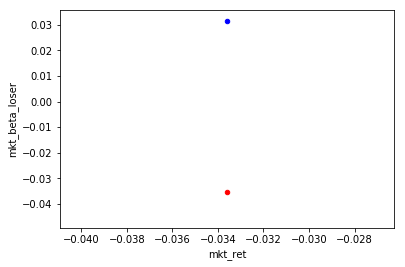

C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned


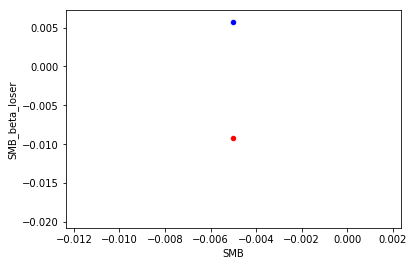

C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned


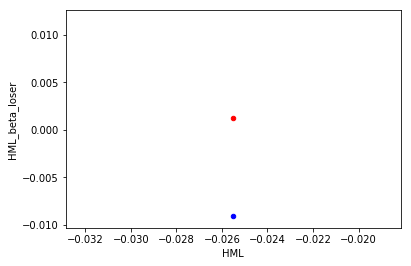

C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned


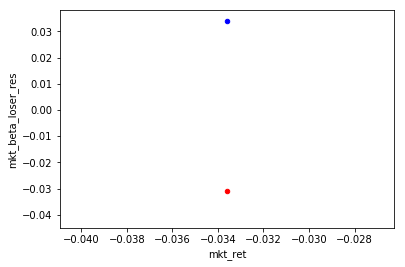

C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned


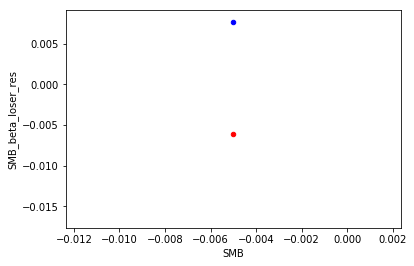

C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
C:\Users\Robin\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned


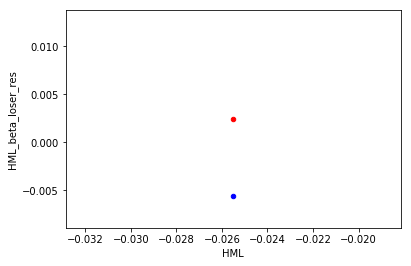

In [112]:
result = pd.DataFrame({'YearMonth':dates,
                    'mkt_beta_winner': mkt_beta_winner_output,
                    'SMB_beta_winner': SMB_beta_winner_output,
                    'HML_beta_winner': HML_beta_winner_output,
                    'mkt_beta_loser': mkt_beta_loser_output,
                    'SMB_beta_loser': SMB_beta_loser_output,
                    'HML_beta_loser': HML_beta_loser_output,
                    'mkt_beta_winner_res': residual_mkt_beta_winner_output,
                    'SMB_beta_winner_res': residual_SMB_beta_winner_output,
                    'HML_beta_winner_res': residual_HML_beta_winner_output,
                    'mkt_beta_loser_res': residual_mkt_beta_loser_output,
                    'SMB_beta_loser_res': residual_SMB_beta_loser_output,
                    'HML_beta_loser_res': residual_HML_beta_loser_output})
final_df = pd.merge(result, ff_ret, how='left', on=['YearMonth'])
#print(final_df.head())
final_df[['mkt_ret','SMB','HML']] = final_df[['mkt_ret','SMB','HML']].shift(1)
final_df = final_df.dropna()
#print(final_df.head())
graph_list = [['mkt_ret','mkt_beta_winner','mkt_beta_loser'],
              ['SMB','SMB_beta_winner','SMB_beta_loser'],
              ['HML','HML_beta_winner','HML_beta_loser'],
              ['mkt_ret','mkt_beta_winner_res','mkt_beta_loser_res'],
              ['SMB','SMB_beta_winner_res','SMB_beta_loser_res'],
              ['HML','HML_beta_winner_res','HML_beta_loser_res']]

for i in range(6):
    graph_betas(final_df, graph_list[i])

In [113]:
a = pd.DataFrame()
a['winner'] = ['a','a','b','a','b','b']
a['RET'] = [2,3,4,5,6,9]
#a['winner'] = a['winner'].shift(1)
print(a)
a['RET'] = a.groupby(['winner'])['RET'].apply(lambda x: x.shift(1))
#a = a.dropna()
print(a)

  winner  RET
0      a    2
1      a    3
2      b    4
3      a    5
4      b    6
5      b    9
  winner  RET
0      a  NaN
1      a  2.0
2      b  NaN
3      a  3.0
4      b  4.0
5      b  6.0


In [57]:
final_df_copy = final_df
final_df

,YearMonth,mkt_beta_winner,SMB_beta_winner,HML_beta_winner,mkt_beta_loser,SMB_beta_loser,HML_beta_loser,mkt_beta_winner_res,SMB_beta_winner_res,HML_beta_winner_res,mkt_beta_loser_res,SMB_beta_loser_res,HML_beta_loser_res,mkt_ret,SMB,HML,RF
1,193002,-0.042446,0.003270,0.004651,0.031243,-0.006077,0.011355,-0.038232,-0.005941,-0.000806,0.030121,-0.007211,0.003624,0.0561,0.0358,-0.0101,0.0030
2,193003,-0.029031,0.002764,-0.002815,0.032239,-0.001949,-0.002104,-0.028625,0.001905,0.003968,0.036093,0.000208,0.000869,0.0250,0.0012,0.0039,0.0035
3,193004,-0.022555,0.010210,-0.000856,0.045360,0.010764,0.000495,-0.018132,0.005922,-0.001593,0.022693,0.001282,-0.002213,0.0710,0.0344,0.0015,0.0021
4,193005,-0.075396,-0.011898,-0.011600,0.061082,-0.015689,-0.004120,-0.056628,-0.001716,-0.002526,0.058179,-0.010626,-0.002743,-0.0206,-0.0017,-0.0084,0.0026
5,193006,-0.212916,0.054895,-0.036405,0.111209,-0.012609,-0.022958,-0.105250,0.030759,-0.014678,0.072078,-0.004943,-0.014876,-0.0166,-0.0204,-0.0063,0.0027
6,193007,-0.064875,-0.007586,0.001943,0.048240,-0.018449,-0.001043,-0.027897,0.000015,0.002576,0.046406,-0.008784,0.007969,-0.1627,-0.0322,0.0200,0.0020
7,193008,-0.096351,0.008460,0.013267,0.057072,-0.017643,0.010894,-0.058544,0.008765,0.006143,0.044290,-0.011998,0.007471,0.0412,-0.0037,-0.0156,0.0009
8,193009,-0.024871,0.006345,-0.001697,0.032170,-0.001057,-0.002969,-0.025516,0.003158,0.004031,0.023557,-0.001610,-0.001268,0.0030,-0.0222,-0.0078,0.0022
9,193010,-0.062258,0.004692,0.010315,0.044222,-0.005825,-0.000691,-0.049459,0.002137,0.008768,0.055005,-0.012450,0.006990,-0.1275,-0.0222,-0.0527,0.0009
